## Mod 6 Lecture 4 Data Challenge:  Simple Linear Regression

### Purpose

**Purpose**: Run a simple linear regression (SLR) on the NYC Yellow Taxi Dec 2023 excerpt to explain how a single input (X) relates to Tip % (Y). Practice picking a sensible X, fitting the line, and interpreting β₁, p‑value, and 95% confidence interval—plus basic assumption checks.

### Data
We are looking at ONE month's worth of data (December 2023 to be exact).  Remember the data dictionary is found [HERE](https://data.cityofnewyork.us/Transportation/2023-Yellow-Taxi-Trip-Data/4b4i-vvec/about_data)

### Instructor Guidance (10 Minutes)

#### Goals

- Pick an X with a plausible relationship to Tip % that is available at trip time.

- Communicate β₁ with units, p-vale, and a 95% CI.

#### Special considerations

- `Tip %` is `tip_amount / fare_amount`. Choosing `fare_amount` as X can create a built‑in relationship because it’s in the definition of Y (mathematical coupling). Encourage alternative X’s like `trip_distance`, `pickup_hour (as numeric)`, or `passenger_count`.

- Linearity check: Is the relationship roughly straight‑line? If X is discrete (e.g., passenger_count), SLR still works but discuss meaning.

- Intercept meaning: If X=0 is unrealistic (0 miles), say the intercept is just a mathematical anchor.

- Outliers: Large distances/fares can dominate. Consider trimming extremes thoughtfully or explaining how you would handle outliers.  

#### Critical thinking prompts as you work through the challenge (be prepared to answer at the end):

- Which input would you use to make a decision before the ride starts? Why?

- If β₁ is tiny but the p‑value is very small, is that useful for the business?

- If residuals (can only get residuals after fitting the model) "fan out" as X grows, what story might that tell about tipping behavior?

- Would your conclusion change if you looked at daytime vs. late night rides separately?

### Student Tasks (35 minutes)

Step 0 — Load Packages and Data, Fix Data Types, Create Tip % Column 

**Hint**:  You did this in the Code-Along, refer back to the notebook to help you!

In [47]:
# import packages
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('/Users/Marcy_Student/Desktop/Marcy_Lab/DA2025_Lectures/Mod6/data/2023_Yellow_Taxi_Trip_Data_20251015.csv', low_memory=False)
display(df.head())
display(df.info())
display(df.describe())

In [29]:
# Coerce fare, tip, distance to numeric safely
num_cols = ['fare_amount', 'tip_amount', 'trip_distance', 'passenger_count']
for c in num_cols:
    df[c] = pd.to_numeric(
        df[c].astype(str).str.strip().str.replace(r'[^0-9.+\-eE]', '', regex=True),
        errors='coerce')

Step 1 — Choose Your X (be sure to chose an X variable that would be available at trip time (not after the trip takes place))

Add a 2–3 sentence rationale in Markdown: Why could X relate to `tip_pct`? Why is it available **when the decision is made** (meaning driver has the information before the actual drive takes place)?

In [30]:
# Clean data some and add a new column called 'tip_pct' as the target 
df = df[(df['fare_amount'] > 0) & (df['tip_amount'] >= 0) & (df['trip_distance'] > 0) & (df['passenger_count'] > 0)]
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=num_cols)
df['tip_pct'] = (df['tip_amount'] / df['passenger_count']).clip(0,1)

I choose the variable `Passenger count` because more passengers might mean a larger total tip in general (even if divided among them), they often leave a large tip as a group, and as group that could mean more effort for the drive like helping with laugage. Also, the passenger count is available when the decision is made because the driver can see how many passengers get in the car before driving begins. The ride request (Uber for instance the number of passengers) before getting a ride.

Step 2 — Quick Visual Check (Linearity & Outliers)

Add a 2-3 sentence rationale on how you would handle outliers or how you did handle outliers (if you handled them for this challenge).  Is the linear relationship there between your X and Y?  Is it a strong relationship?  What is the benefits of a strong relationship between X and Y?

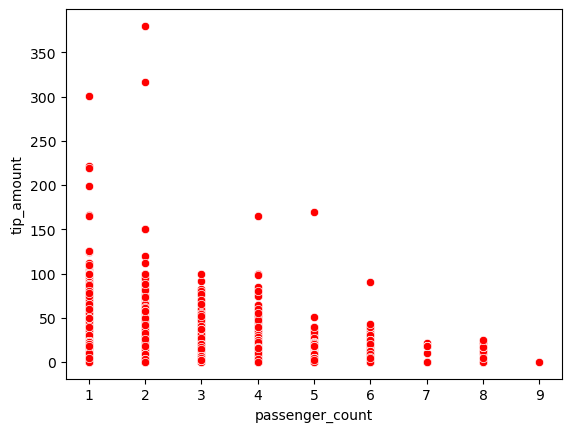

In [19]:
import matplotlib.pyplot as plt 
import seaborn as sns   
fig = plt.figure()
sns.scatterplot(data=df, x='passenger_count', y='tip_amount', color='red')
plt.show()

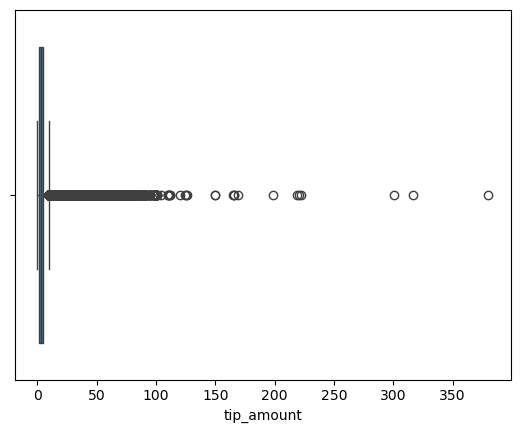

In [31]:
sns.boxplot(x=df['tip_amount'])
plt.show()

To handle outliers, i'll first use a box plot in seaborn to make sure that i had some tip amount that are extremely high, and next find and dectect all the values bellow and above my threshold using the interquartile range. I will then decide to ignore them when building my model, or just delete them. 

In [32]:
Q1 = df['tip_amount'].quantile(0.25)
Q3 = df['tip_amount'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['tip_amount'] >= Q1 - 1.5*IQR) & (df['tip_amount'] <= Q3 + 1.5*IQR)]

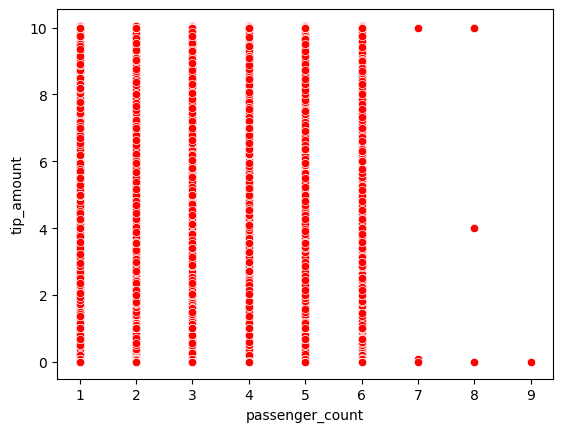

In [33]:
import matplotlib.pyplot as plt 
import seaborn as sns   
fig = plt.figure()
sns.scatterplot(data=df, x='passenger_count', y='tip_amount', color='red')
plt.show()

Step 3 — Fit SLR Model to Data

In [34]:
import statsmodels.api as sm

x = sm.add_constant(df[['passenger_count']])  # independent variable(s)
y = df['tip_pct']  # dependent variable

model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                tip_pct   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                 6.273e+04
Date:                Mon, 27 Oct 2025   Prob (F-statistic):               0.00
Time:                        13:34:17   Log-Likelihood:            -1.5530e+06
No. Observations:             2815404   AIC:                         3.106e+06
Df Residuals:                 2815402   BIC:                         3.106e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.8443      0.000   18

In [36]:
tips_vs_passenger_count = ols('tip_pct ~ passenger_count', data=df).fit()
print(tips_vs_passenger_count.params)

Intercept          0.844310
passenger_count   -0.069504
dtype: float64


In [21]:
X = df[['passenger_count']]
y = df[['tip_pct']]
lin = LinearRegression().fit(X, y) #default fits intercept 
print('Intercept (β₀):', lin.intercept_)
print('Slope (β₁):', lin.coef_[0])

Intercept (β₀): [0.85239748]
Slope (β₁): [-0.06305456]


### From this formula: Y = β₀ + β₁X
in the analysis:
- Y = `tip_pct`
- X = `passenger count`
- Intercept (β₀) = 0.844310
- Slope (β₁) = -0.069504
    - so we get: `tip_pct = 0.844310 - 0.069504 * passenger count`

Step 4 — Interpret the model's coefficients, p-values, and CI 

## Interpretation: 
the model predicts that:
- When there are no passengers (hypothetically), the expected tip percentage would be about 0.8443 (or 84.4%).
- For each additional passenger, the tip percentage decreases by 0.0695 (≈ 7%).

- There is a negative relationship between passenger_count and tip_pct.
- As the number of passengers increases, the tip percentage tends to go down.
- The p-value for passenger_count is 0.000, which means this relationship is statistically significant, it’s very unlikely to be due to random chance.

Step 5 — Post‑Fit Assumption Glance 

Add 2-3 sentences about the residuals any curve? funnel shape? obvious outliers?  How would you go about checking if residuals were normally distributed?  

In [38]:
tips_vs_passenger_count.fittedvalues

0          0.705302
1          0.635798
3          0.774806
4          0.705302
6          0.774806
             ...   
3310899    0.705302
3310900    0.705302
3310901    0.774806
3310902    0.635798
3310906    0.774806
Length: 2815404, dtype: float64

In [39]:
tips_vs_passenger_count.resid

0          0.294698
1         -0.635798
3         -0.774806
4          0.294698
6         -0.774806
             ...   
3310899    0.294698
3310900   -0.705302
3310901   -0.774806
3310902    0.150869
3310906    0.225194
Length: 2815404, dtype: float64

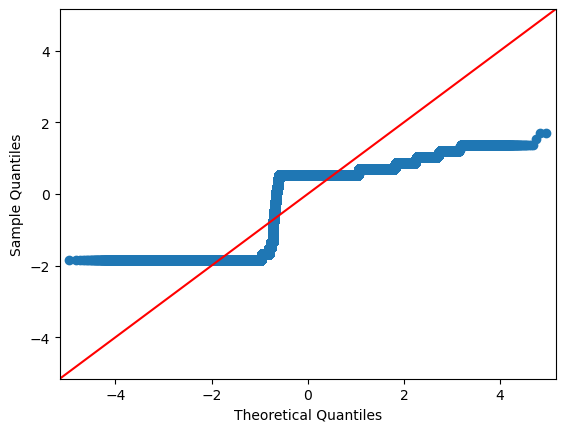

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

residuals = model.resid
sm.qqplot(residuals, line='45', fit=True)  # Q–Q plot
plt.show()

The residual plot shows no clear curve or funnel shape, suggesting that the relationship between passenger count and tip percentage is roughly linear and that the variance of the residuals is fairly constant across values of passenger count. However, a few potential outliers may still exist.

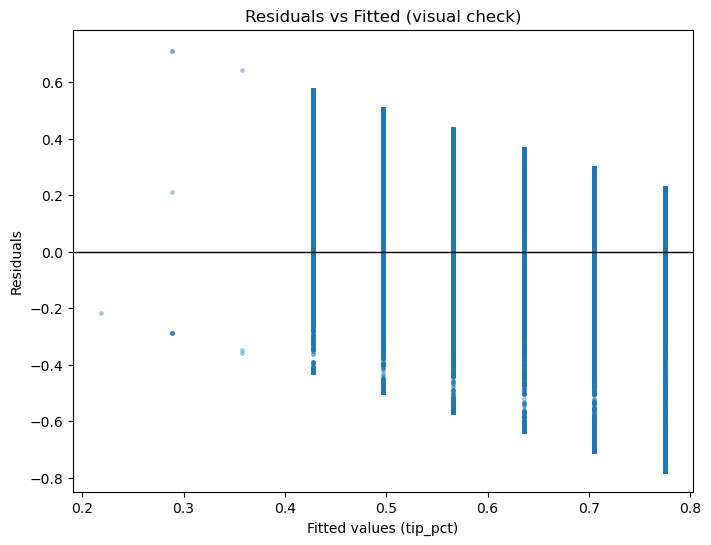

In [46]:
#RUN THIS CELL WITHOUT CHANGES
resid = model.resid
fitted = model.fittedvalues
plt.figure(figsize=(8,6))
plt.scatter(fitted, resid, s=6, alpha=0.3)
plt.axhline(0, color='k', lw=1)
plt.xlabel('Fitted values (tip_pct)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted (visual check)')
plt.show()

### Reflection (10-15 mins)

**In addition to the critical thinking questions at the top** of the notebook be prepared to discuss: 

- If you had to make a decision tomorrow, would this simple model be enough? Why/why not?

- What’s one different X you’d try next and why?